## 1. Visualizations

In [ ]:
! pip install -Uq matplotlib spacy torchdata

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from architecture.utils import subsequent_mask, PositionalEncoding
from architecture.transformer import make_model, EncoderDecoder
from optimize import LabelSmoothing, SimpleLoss, get_lr, get_scheduler, DummyOptimizer, DummyScheduler

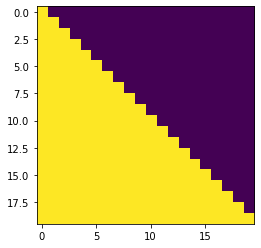

In [3]:
# Token masking
plt.imshow(subsequent_mask(20)[0])
None

In [ ]:
# Positional encoding
pe = PositionalEncoding(d_model=20)
y = pe(torch.zeros(1, 100, 20))

plt.plot(torch.arange(100), y[0, :, 4:8])
plt.legend([f"dim {p}" for p in range(4, 8)])
None

In [ ]:
# Noam learning rate scheduler

h_params = ((512, 4000), (512, 8000), (256, 4000))
opts = [
    [get_lr(step, d_model=d_model, scale=1., n_warmup_steps=steps) for d_model, steps in h_params]
    for step in range(1, 20000)
]

plt.plot(torch.arange(1, 20000), opts)
plt.legend([f"{d_model}:{steps}" for d_model, steps in h_params])
None

In [ ]:
# same graph as above but actually running the scheduler on a dummy model

dummy_model = nn.Linear(1, 1)
lr = []

for i, (d_model, n_warmup_steps) in enumerate(h_params):
    optimizer, lr_scheduler = get_scheduler(dummy_model, d_model=d_model, n_warmup_steps=n_warmup_steps, lr=1.)
    tmp = []
    for step in range(20000):
        tmp.append(optimizer.param_groups[0]['lr'])
        optimizer.step()
        lr_scheduler.step()
    lr.append(tmp)

plt.plot(torch.arange(0, 20000), list(zip(*lr)))
plt.legend([f"{d_model}:{steps}" for d_model, steps in h_params])
None

In [ ]:
# Label smoothing
crit = LabelSmoothing(n_classes=5, padding_idx=0, smoothing=0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0] for _ in range(5)])
v = crit(predict.log(), torch.LongTensor([2, 1, 0, 3, 3]))

plt.imshow(crit.true_dist)
None

In [ ]:
def loss(x, smoothing=0.1):
    crit = LabelSmoothing(5, 0, smoothing)
    
    d = x + 3
    predict = torch.FloatTensor([[0, x/d, 1/d, 1/d, 1/d]])
    
    return crit(predict.log(), torch.LongTensor([1])).item()

smoothing = (0.1, 0.3, 0.5)
plt.plot(torch.arange(1, 100), [[loss(x, s) for s in smoothing] for x in range(1, 100)])
plt.legend(smoothing)
plt.ylabel("Loss")
plt.xlabel("Confidence")
None

## 2. Training the copy task

In [ ]:
from architecture.transformer import ModelConfig
from train import run_epoch
from preprocess import Batch
from tqdm import tqdm, trange

In [ ]:
n_vocab = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def data_gen(n_vocab: int, batch_size: int, n_batches: int):
    for i in range(n_batches):
        data = torch.randint(1, n_vocab, size=(batch_size, 10)).detach()
        data[:, 0] = 1
        yield Batch(src=data.clone(), tgt=data.clone(), pad_token=0)

In [ ]:
def train_copy(model: nn.Module):
    criterion = LabelSmoothing(n_classes=n_vocab, padding_idx=0, smoothing=0.)

    loss_fn = SimpleLoss(model.generator, criterion)
    optimizer, scheduler = get_scheduler(model)

    for epoch in trange(1, 11, desc="Epoch"):
        model.train()
        fake_data = data_gen(n_vocab, batch_size=30, n_batches=20)
        run_epoch(
            fake_data,
            model,
            loss_compute=loss_fn,
            optimizer=optimizer,
            scheduler=scheduler,
            mode="train"
        )

        with torch.no_grad():
            model.eval()
            fake_valid = data_gen(n_vocab, batch_size=30, n_batches=5)
            run_epoch(
                fake_valid,
                model,
                loss_fn,
                DummyOptimizer(),
                DummyScheduler(),
                mode="eval"
            )

In [ ]:
model_cfg = ModelConfig(n_vocab, n_vocab, n_layers=2)
model = make_model(model_cfg)

In [ ]:
train_copy(model)

In [ ]:
model_path = 'models/copy_10_epochs.pt'

if True:
    torch.save(model.state_dict(), model_path)
    print(f'saved model to {model_path}')

if False:
    state_dict = torch.load(model_path)
    model = make_model(model_cfg)
    model.load_state_dict(state_dict)
    print(f'loaded model from {model_path}')

In [ ]:
# evaluate it on the copy task

seq_len = 10
model.eval()
with torch.no_grad():
    for i in range(10):
        src = torch.empty(1, seq_len, dtype=torch.long)
        src[0, 0] = 1
        src[0, 1:] = torch.randint(2, n_vocab, size=(1, seq_len - 1))
        src_mask = torch.ones(1, 1, seq_len, dtype=torch.bool)
        output = model.greedy_decode(src, src_mask, n_ctx=seq_len, start_token=1)
        print(torch.cat((src, output)))

## To the real world

In [ ]:
! python -m spacy download en_core_web_sm > /dev/null
! python -m spacy download de_core_news_sm > /dev/null

In [ ]:
! pip install -Uq GPUtil torchdata

In [ ]:
from train import train_model, TrainingConfig
from preprocess import build_vocab
import spacy, os

spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [ ]:
vocab_src, vocab_tgt = build_vocab(spacy_de, spacy_en)
len(vocab_src), len(vocab_tgt)

In [ ]:
model_cfg = ModelConfig(n_src_vocab=len(vocab_src), n_tgt_vocab=len(vocab_tgt))

train_cfg = TrainingConfig(
    batch_size = 32,
    distributed = True,
    n_epochs = 8,
    accum_interval = 10,
    lr_init = 1.,
    n_ctx = 72,
    n_warmup_steps = 3000,
    file_prefix = "models/multi30k_epoch_"
)

In [ ]:
train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, model_cfg, train_cfg)